In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from env import host, user, password

# Wrangling
import pandas as pd
import numpy as np

# Exploring
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns



In [2]:
#URL function
def get_db_url(host, user, password, database):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'

In [3]:
#Declare the database and url
database = 'zillow'

url = get_db_url(host, user, password, database)

In [4]:
#Create the SQL query
query = '''
        SELECT prop.*,
        predictions_2017.logerror,
        predictions_2017.transactiondate,
        air.airconditioningdesc,
        arch.architecturalstyledesc,
        build.buildingclassdesc,
        heat.heatingorsystemdesc,
        land.propertylandusedesc,
        story.storydesc,
        type.typeconstructiondesc
        FROM properties_2017 prop
        JOIN (
            SELECT parcelid, MAX(transactiondate) AS max_transactiondate
            FROM predictions_2017
            GROUP BY parcelid
            ) pred USING(parcelid)
        JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                          AND pred.max_transactiondate = predictions_2017.transactiondate
        LEFT JOIN airconditioningtype air USING(airconditioningtypeid)
        LEFT JOIN architecturalstyletype arch USING(architecturalstyletypeid)
        LEFT JOIN buildingclasstype build USING(buildingclasstypeid)
        LEFT JOIN heatingorsystemtype heat USING(heatingorsystemtypeid)
        LEFT JOIN propertylandusetype land USING(propertylandusetypeid)
        LEFT JOIN storytype story USING(storytypeid)
        LEFT JOIN typeconstructiontype type USING(typeconstructiontypeid)
        WHERE propertylandusedesc = "Single Family Residential"
            AND transactiondate <= '2017-12-31'
            AND prop.longitude IS NOT NULL
            AND prop.latitude IS NOT NULL
        '''

In [5]:
#Read in the dataframe
df = pd.read_sql(query, url)

df.head()

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,None,NaN,3.5,...,6.059063e+13,0.025595,2017-01-01,None,None,None,None,Single Family Residential,None,None
1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,None,NaN,1.0,...,6.111001e+13,0.055619,2017-01-01,None,None,None,None,Single Family Residential,None,None
2,11677,14186244,NaN,NaN,NaN,2.0,3.0,None,NaN,2.0,...,6.059022e+13,0.005383,2017-01-01,None,None,None,None,Single Family Residential,None,None
3,2288172,12177905,NaN,NaN,NaN,3.0,4.0,None,8.0,3.0,...,6.037300e+13,-0.103410,2017-01-01,None,None,None,Central,Single Family Residential,None,None
4,781532,12095076,1.0,NaN,NaN,3.0,4.0,None,9.0,3.0,...,6.037461e+13,-0.001011,2017-01-01,Central,None,None,Central,Single Family Residential,None,None


In [6]:
#Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,52319.0,1.496888e+06,8.594310e+05,3.490000e+02,7.575810e+05,1.500095e+06,2.241248e+06,2.982270e+06
parcelid,52319.0,1.299682e+07,3.350951e+06,1.071186e+07,1.151017e+07,1.257825e+07,1.413036e+07,1.676878e+08
airconditioningtypeid,13615.0,2.439589e+00,3.847925e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.300000e+01
architecturalstyletypeid,70.0,7.100000e+00,2.665670e+00,2.000000e+00,7.000000e+00,7.000000e+00,7.000000e+00,2.100000e+01
basementsqft,47.0,6.789787e+02,7.118252e+02,3.800000e+01,2.635000e+02,5.120000e+02,8.095000e+02,3.560000e+03
bathroomcnt,52319.0,2.300015e+00,1.022816e+00,0.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
bedroomcnt,52319.0,3.300770e+00,9.475632e-01,0.000000e+00,3.000000e+00,3.000000e+00,4.000000e+00,1.400000e+01
buildingqualitytypeid,33654.0,6.264961e+00,1.716328e+00,1.000000e+00,5.000000e+00,6.000000e+00,8.000000e+00,1.200000e+01
calculatedbathnbr,52184.0,2.305276e+00,1.018076e+00,1.000000e+00,2.000000e+00,2.000000e+00,3.000000e+00,1.800000e+01
decktypeid,389.0,6.600000e+01,0.000000e+00,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01,6.600000e+01


In [7]:
#Info on the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52319 entries, 0 to 52318
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52319 non-null  int64  
 1   parcelid                      52319 non-null  int64  
 2   airconditioningtypeid         13615 non-null  float64
 3   architecturalstyletypeid      70 non-null     float64
 4   basementsqft                  47 non-null     float64
 5   bathroomcnt                   52319 non-null  float64
 6   bedroomcnt                    52319 non-null  float64
 7   buildingclasstypeid           0 non-null      object 
 8   buildingqualitytypeid         33654 non-null  float64
 9   calculatedbathnbr             52184 non-null  float64
 10  decktypeid                    389 non-null    float64
 11  finishedfloor1squarefeet      4371 non-null   float64
 12  calculatedfinishedsquarefeet  52238 non-null  float64
 13  f

In [8]:
#Shape of the dataframe
df.shape

(52319, 68)

(-1.0, 1.0)

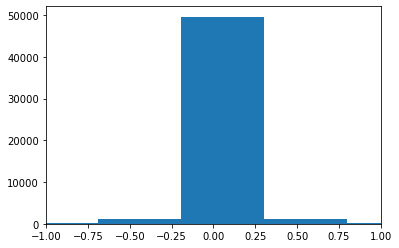

In [9]:
#Distribution of target variable
plt.hist(x=df['logerror'], bins=20)
plt.xlim(-1, 1)

In [10]:
#Value counts of the poolcnt column
df['poolcnt'].value_counts()

1.0    11077
Name: poolcnt, dtype: int64

In [11]:
#Define function to calculate number and percent of values missing from each column
def null_counter(df):
    
    new_columns = ['name', 'num_rows_missing', 'pct_rows_missing']
    
    new_df = pd.DataFrame(columns=new_columns)
    
    for col in list(df.columns):
        num_missing = df[col].isna().sum()
        pct_missing = num_missing / df.shape[0]
        
        add_df = pd.DataFrame([{'name': col, 'num_rows_missing': num_missing,
                               'pct_rows_missing': pct_missing}])
        
        new_df = pd.concat([new_df, add_df], axis=0)
        
    new_df.set_index('name', inplace=True)
    
    return new_df

In [12]:
#Execute my function and verify the results
null_df = null_counter(df)

null_df.head()

,num_rows_missing,pct_rows_missing
name,,
id,0,0.0
parcelid,0,0.0
airconditioningtypeid,38704,0.739769
architecturalstyletypeid,52249,0.998662
basementsqft,52272,0.999102


In [13]:
#Check the shape to make sure I capture all columns
null_df.shape

(68, 2)

# Prepare

In [14]:
#Maybe there are some houses with no square footage?
df[df['calculatedfinishedsquarefeet'] == 0]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc


In [15]:
#What about nonexistent lots?
df[df['lotsizesquarefeet'] == 0]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc


In [16]:
#Maybe ones that have no bedrooms?
df[df['bedroomcnt'] == 0]

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
124,2546776,14190895,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,6.059022e+13,-0.001296,2017-01-03,None,None,None,None,Single Family Residential,None,None
590,2062723,11662937,NaN,NaN,NaN,5.0,0.0,None,10.0,5.0,...,6.037263e+13,0.015158,2017-01-05,None,None,None,None,Single Family Residential,None,None
2602,496818,11696784,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,6.037235e+13,-0.124790,2017-06-16,None,None,None,Floor/Wall,Single Family Residential,None,None
2683,1602501,12227894,NaN,NaN,NaN,0.0,0.0,None,4.0,NaN,...,6.037241e+13,-0.024661,2017-01-19,None,None,None,None,Single Family Residential,None,None
2887,856504,12146026,NaN,NaN,NaN,0.0,0.0,None,NaN,NaN,...,6.037431e+13,-0.661313,2017-01-20,None,None,None,None,Single Family Residential,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51689,1341842,11784034,1.0,NaN,NaN,1.0,0.0,None,NaN,1.0,...,6.037207e+13,0.025360,2017-09-14,Central,None,None,Central,Single Family Residential,None,None
52041,1759759,12399434,NaN,NaN,NaN,0.0,0.0,None,6.0,NaN,...,6.037551e+13,0.509534,2017-09-18,None,None,None,Central,Single Family Residential,None,None
52053,2004419,12000984,NaN,NaN,NaN,1.0,0.0,None,8.0,1.0,...,6.037700e+13,-0.554524,2017-09-18,None,None,None,None,Single Family Residential,None,None
52266,342540,11784041,1.0,NaN,NaN,1.0,0.0,None,NaN,1.0,...,6.037207e+13,0.009603,2017-09-19,Central,None,None,Central,Single Family Residential,None,None


In [17]:
#Define function to drop columns/rows based on proportion of nulls
def null_dropper(df, prop_required_column, prop_required_row):
    
    prop_null_column = 1 - prop_required_column
    
    for col in list(df.columns):
        
        null_sum = df[col].isna().sum()
        null_pct = null_sum / df.shape[0]
        
        if null_pct > prop_null_column:
            df.drop(columns=col, inplace=True)
            
    row_threshold = int(prop_required_row * df.shape[1])
    
    df.dropna(axis=0, thresh=row_threshold, inplace=True)
    
    return df

In [18]:
#Execute my function and visualize the results
clean_df = null_dropper(df, 0.75, 0.75)

In [19]:
clean_df.head()

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,propertylandusedesc
0,1727539,14297519,3.5,4.0,3.5,3100.0,3100.0,6059.0,3.0,33634931.0,...,1998.0,485713.0,1023282.0,2016.0,537569.0,11013.72,6.059063e+13,0.025595,2017-01-01,Single Family Residential
1,1387261,17052889,1.0,2.0,1.0,1465.0,1465.0,6111.0,1.0,34449266.0,...,1967.0,88000.0,464000.0,2016.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,Single Family Residential
2,11677,14186244,2.0,3.0,2.0,1243.0,1243.0,6059.0,2.0,33886168.0,...,1962.0,85289.0,564778.0,2016.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,Single Family Residential
3,2288172,12177905,3.0,4.0,3.0,2376.0,2376.0,6037.0,3.0,34245180.0,...,1970.0,108918.0,145143.0,2016.0,36225.0,1777.51,6.037300e+13,-0.103410,2017-01-01,Single Family Residential
4,781532,12095076,3.0,4.0,3.0,2962.0,2962.0,6037.0,3.0,34145202.0,...,1950.0,276684.0,773303.0,2016.0,496619.0,9516.26,6.037461e+13,-0.001011,2017-01-01,Single Family Residential


In [20]:
df=clean_df

In [21]:
#Check shape of resulting dataframe
df.shape

(52317, 29)

In [22]:
#Save a copy of the clean csv to my local machine
df.to_csv('zillow.csv')

In [23]:
df.columns

Index(['id', 'parcelid', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'yearbuilt', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'censustractandblock', 'logerror', 'transactiondate',
       'propertylandusedesc'],
      dtype='object')

In [24]:
test_results = stats.pearsonr(df.bathroomcnt, df.logerror)
test_results


(0.035999290920095135, 1.772355804082405e-16)

In [25]:
r, p = test_results

print(f'p is {p:.10f}')


p is 0.0000000000


In [26]:
test_results = stats.pearsonr(df.bedroomcnt, df.logerror)
test_results


(0.03932853943484667, 2.2809913057294533e-19)

In [27]:
r, p = test_results

print(f'p is {p:.10f}')


p is 0.0000000000


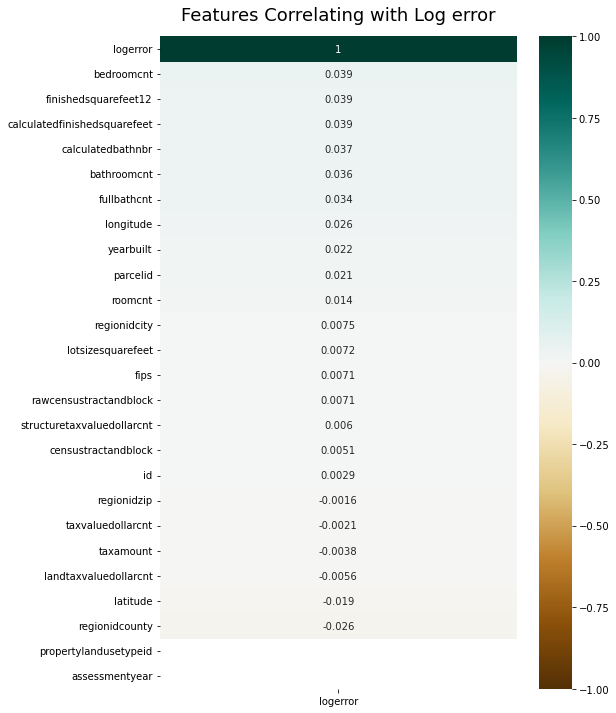

In [28]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr(method='pearson')[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Log error', fontdict={'fontsize':18}, pad=16);

In [29]:
spearman_corr= df.corr(method='spearman')
spearman_corr

,id,parcelid,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,latitude,...,regionidzip,roomcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
id,1.000000,-0.005300,-0.000712,-0.001101,-0.000704,-0.000221,0.000065,-0.007424,-0.000595,-0.006736,...,-0.005148,-0.008518,-0.000333,0.000035,-0.001685,NaN,-0.001195,-0.001406,-0.003974,-0.000114
parcelid,-0.005300,1.000000,0.115814,0.120450,0.118438,0.120986,0.123296,0.841810,0.029965,-0.525817,...,0.395432,0.685970,0.307512,0.087643,0.137871,NaN,0.132009,0.075263,0.757096,0.031337
bathroomcnt,-0.000712,0.115814,1.000000,0.639852,1.000000,0.839028,0.839068,0.187560,0.971450,-0.011762,...,0.201636,0.098718,0.588512,0.684411,0.487343,NaN,0.316029,0.494384,0.176622,0.069905
bedroomcnt,-0.001101,0.120450,0.639852,1.000000,0.637730,0.669617,0.668661,0.168007,0.630327,0.010259,...,0.190842,0.164771,0.428050,0.456025,0.295271,NaN,0.164780,0.304161,0.181651,0.063690
calculatedbathnbr,-0.000704,0.118438,1.000000,0.637730,1.000000,0.840209,0.839965,0.191056,0.971450,-0.012461,...,0.203861,0.097623,0.589004,0.689150,0.491158,NaN,0.318790,0.498174,0.179635,0.070199
calculatedfinishedsquarefeet,-0.000221,0.120986,0.839028,0.669617,0.840209,1.000000,1.000000,0.190123,0.811118,-0.018098,...,0.173690,0.120577,0.528018,0.730501,0.529142,NaN,0.346820,0.534717,0.162979,0.076109
finishedsquarefeet12,0.000065,0.123296,0.839068,0.668661,0.839965,1.000000,1.000000,0.194633,0.810716,-0.021415,...,0.176205,0.124330,0.527571,0.732036,0.531953,NaN,0.349175,0.537564,0.167198,0.076856
fips,-0.007424,0.841810,0.187560,0.168007,0.191056,0.190123,0.194633,1.000000,0.092344,-0.357842,...,0.565133,0.841954,0.403385,0.142241,0.177133,NaN,0.152064,0.111951,0.842127,0.028509
fullbathcnt,-0.000595,0.029965,0.971450,0.630327,0.971450,0.811118,0.810716,0.092344,1.000000,0.048269,...,0.153171,0.028699,0.532895,0.658998,0.461648,NaN,0.293921,0.475281,0.097990,0.065573
latitude,-0.006736,-0.525817,-0.011762,0.010259,-0.012461,-0.018098,-0.021415,-0.357842,0.048269,1.000000,...,0.093433,-0.274549,-0.008733,0.072685,-0.153822,NaN,-0.240623,-0.100995,-0.325105,-0.025607


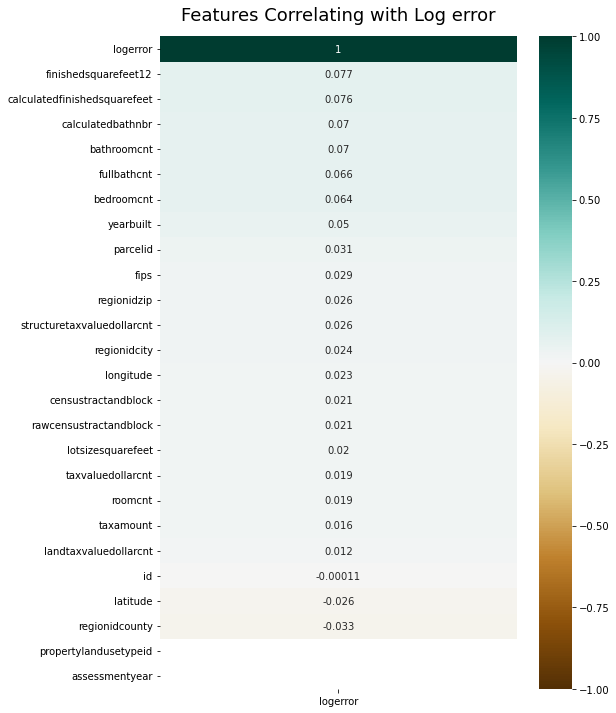

In [30]:
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr(method='spearman')[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Log error', fontdict={'fontsize':18}, pad=16);

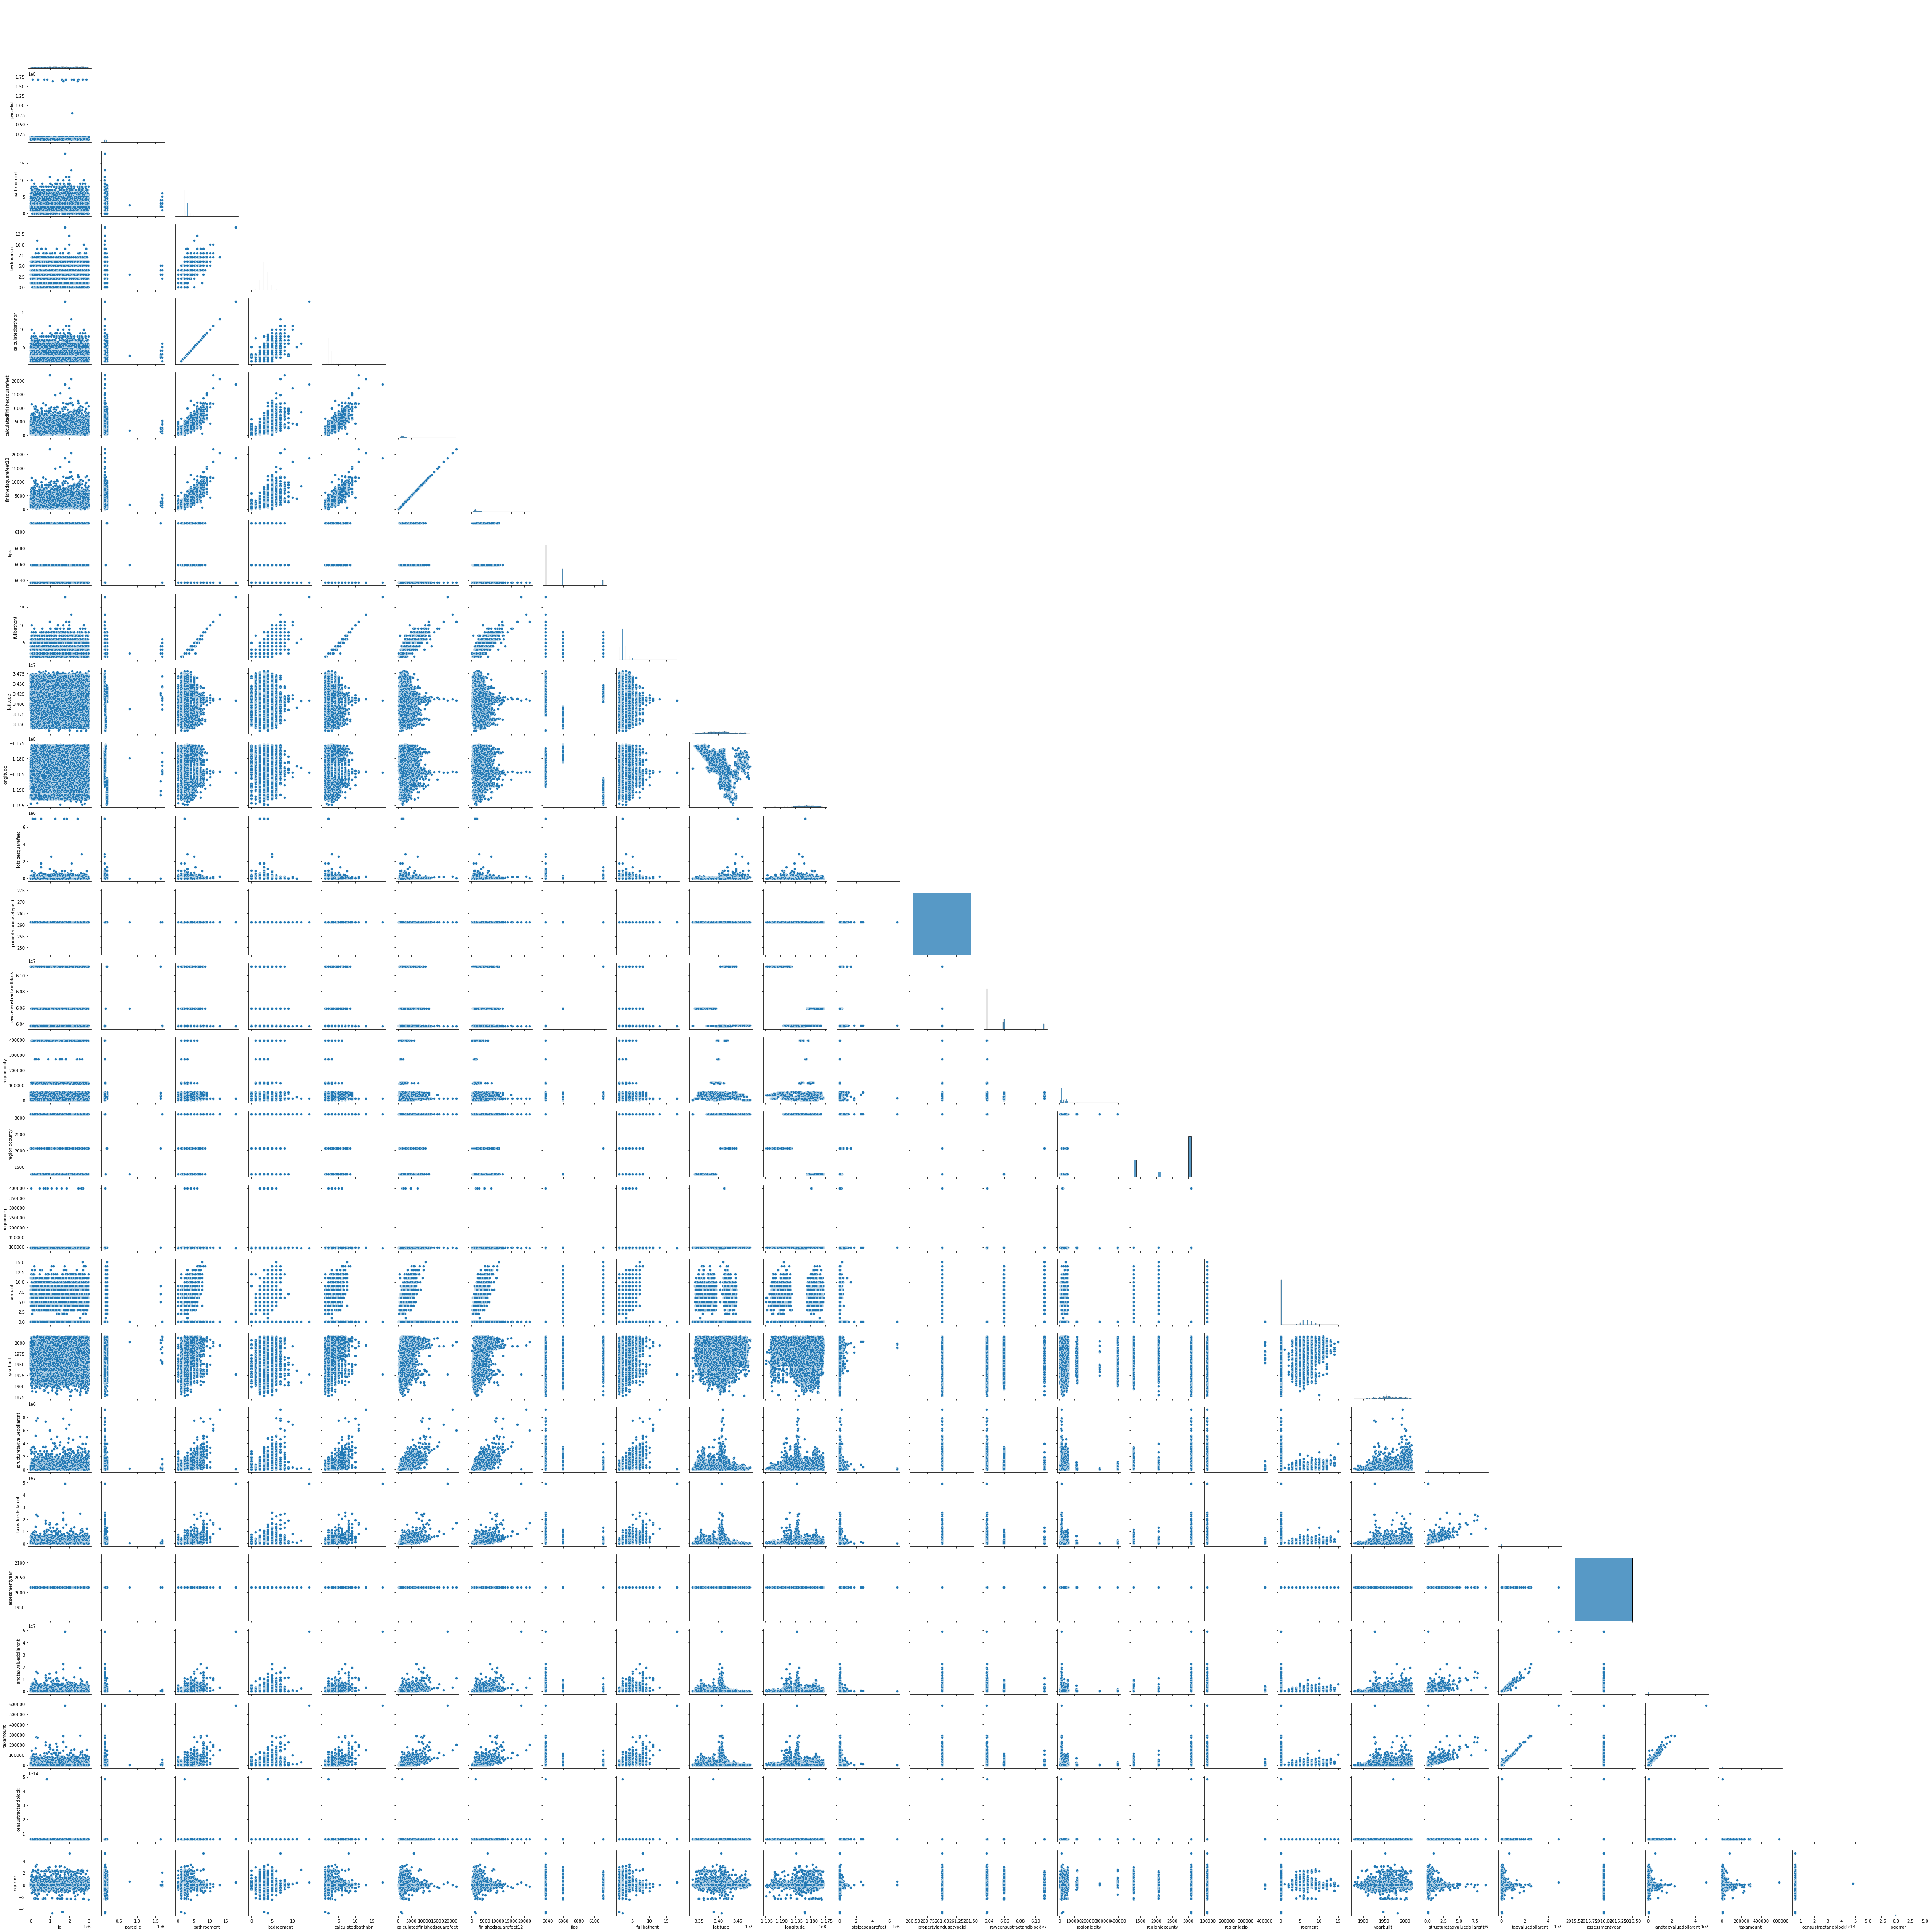

In [32]:
sns.pairplot(df, corner=True)
plt.show()

'regionidcounty'	County in which the property is located
'regionidcity'	 City in which the property is located (if any)
'regionidzip'	 Zip code in which the property is located

In [44]:
df.regionidcounty.unique()

array([1286., 2061., 3101.])

In [45]:
df.regionidcounty.unique().shape

(3,)

In [42]:
df.regionidcity.unique()

array([ 53571.,  13091.,  21412., 396551.,  47019.,  45457.,  14634.,
        54311.,  24832.,  13150.,  32380.,  17882.,  25458.,  52650.,
        12447.,  46298.,  40081.,  54053.,  33252.,  12520.,  46080.,
        45888.,  11626.,  13693.,  52835.,  37015.,  14111., 118694.,
        34636.,  17686.,  25459.,  20008.,  39308.,  12292.,  38980.,
        27491.,  10723., 396054.,  44833.,  47568.,  26531.,  27183.,
        44116.,  16764.,   5534.,   4406.,  24812.,  18874.,     nan,
        10734.,  51239.,  22827.,  41673.,  25953.,  17597.,  10774.,
        12773.,  52842.,  50677.,  26483.,  25218.,  40227.,  15237.,
        16961.,  38032.,  34543.,  30187.,  33837.,  29189.,  24174.,
        34780.,  17150.,  50749.,  10608.,  37086.,  16389.,  34278.,
        40110.,  51861.,  53636.,  26964.,  13716.,  45602., 396556.,
       396550.,  25974.,  27110.,  15554.,  33836.,  14542.,  47198.,
        55753.,  19177.,  54722.,  33612., 118895.,   8384.,  42150.,
       118914.,   60

In [43]:
df.regionidcity.unique().shape

(176,)

In [41]:
df.regionidzip.unique()

array([ 96978.,  97099.,  97078.,  96330.,  96293.,  96325.,  96173.,
        96374.,  97051.,  97107.,  96962.,  96003.,  96971.,  96954.,
        96018.,  96237.,  96957.,  96352.,  96008.,  97005.,  96122.,
        97067.,  96116.,  96271.,  96349.,  96450.,  96447.,  96000.,
        96291.,  96133.,  96486.,  96361.,  96983.,  96998.,  96414.,
        96464.,  96517.,  96982.,  96241.,  96488.,  96522.,  96961.,
        96370.,  96987.,  96366.,  96387.,  96507.,  96506.,  96494.,
        96212.,  96337.,  96049.,  97018.,  96229.,  97079.,  96437.,
        95983.,  96185.,  96025.,  96058.,  97063.,  96452.,  97068.,
        95984.,  96280.,  97003.,  96389.,  96208.,  97024.,  97318.,
        96101.,  97041.,  96186.,  96398.,  97089.,  96384.,  96192.,
        97091.,  96989.,  96136.,  96369.,  96206.,  97106.,  96378.,
        96342.,  96995.,  96426.,  96020.,  96401.,  96969.,  96137.,
        96024.,  96956.,  96531.,  96197.,  96981.,  96967.,  96980.,
        96943.,  973

In [35]:
df.regionidzip.unique().shape

(382,)

In [40]:
df.regionidzip.count()

52293

In [ ]:
array([ 96978.,  97099.,  97078.,  96330.,  96293.,  96325.,  96173.,
        96374.,  97051.,  97107.,  96962.,  96003.,  96971.,  96954.,
        96018.,  96237.,  96957.,  96352.,  96008.,  97005.,  96122.,
        97067.,  96116.,  96271.,  96349.,  96450.,  96447.,  96000.,
        96291.,  96133.,  96486.,  96361.,  96983.,  96998.,  96414.,
        96464.,  96517.,  96982.,  96241.,  96488.,  96522.,  96961.,
        96370.,  96987.,  96366.,  96387.,  96507.,  96506.,  96494.,
        96212.,  96337.,  96049.,  97018.,  96229.,  97079.,  96437.,
        95983.,  96185.,  96025.,  96058.,  97063.,  96452.,  97068.,
        95984.,  96280.,  97003.,  96389.,  96208.,  97024.,  97318.,
        96101.,  97041.,  96186.,  96398.,  97089.,  96384.,  96192.,
        97091.,  96989.,  96136.,  96369.,  96206.,  97106.,  96378.,
        96342.,  96995.,  96426.,  96020.,  96401.,  96969.,  96137.,
        96024.,  96956.,  96531.,  96197.,  96981.,  96967.,  96980.,
        96943.,  97328.,  97020.,  97048.,  96183.,  96451.,  97021.,
        97023.,  97025.,  96083.,  96958.,  97081.,  96265.,  96514.,
        97330.,  96966.,  97323.,  96092.,  96990.,  97084.,  97035.,
        97039.,  97083.,  96268.,  96354.,  96410.,  96180.,  95993.,
        96267.,  97329.,  96004.,  96102.,  96974.,  97004.,  96986.,
        96385.,  96181.,  97317.,  96373.,  96013.,  96023.,  97098.,
        96479.,  96193.,  96383.,  96368.,  96150.,  96201.,  96149.,
        96327.,  96174.,  96489.,  96213.,  96001.,  96284.,  96242.,
        97097.,  96240.,  97116.,  96364.,  96446.,  97118.,  96375.,
        96027.,  96228.,  96993.,  95999.,  96513.,  96523.,  97047.,
        97109.,  96379.,  96103.,  96117.,  96415.,  96163.,  96965.,
        96134.,  96161.,  96123.,  96215.,  97344.,  96490.,  96222.,
        97008.,  96129.,  96524.,  97026.,  96107.,  95987.,  96341.,
        96485.,  96221.,  96496.,  97043.,  96230.,  96296.,  96492.,
        96393.,  96169.,  96505.,  96127.,  96171.,  97319.,  96351.,
        96047.,  96113.,  96497.,  96091.,  96247.,  96100.,  96030.,
        96424.,  96959.,  96533.,  95985.,  96339.,  96046.,  96320.,
        96940.,  96515.,  96449.,  96321.,  97016.,  96292.,  96022.,
        96346.,  96028.,  97066.,  96019.,  96356.,  96475.,  96278.,
        96508.,  96979.,  96124.,  97040.,  96239.,  96473.,  96985.,
        96012.,  97104.,  96106.,  96324.,  96371.,  97006.,  96026.,
        96996.,  96270.,  96111.,  96469.,  96121.,  96016.,  96045.,
        96126.,  96436.,  96005.,  96217.,  96433.,  96120.,  96244.,
        96245.,  95997.,  95989.,  96095.,  96109.,  96326.,  96172.,
        96395.,  96125.,  96975.,  97050.,  97007.,  96377.,  96295.,
        96946.,  96220.,  97065.,  95982.,  96152.,  97101.,  96210.,
        96017.,  96104.,  96510.,  96282.,  97052.,  96090.,  96948.,
        96218.,  96225.,  96474.,  96465.,  96119.,  96044.,  96216.,
        96015.,  96037.,  96951.,  96086.,  97027.,  97059.,  96162.,
        96939.,  96525.,  96190.,  96021.,  96110.,  96014.,  96105.,
        96007.,  96412.,  96246.,  96403.,  96480.,  97094.,  97001.,
        95986.,  96204.,  96273.,  96043.,  96050.,  96160.,  96438.,
        96964.,  96159.,  96207.,  96973.,  96275.,  96006.,  96338.,
        96355.,  96411.,  97037.,  97064.,  96135.,  96294.,  96322.,
        97113.,  96203.,  96478.,  96420.,  96029.,  96040.,  96042.,
        96226.,  97298.,  96097.,  95992.,  96170.,  96128.,  96336.,
        97119.,  96238.,  96952.,  95988.,  97331.,  96087.,     nan,
        97316.,  96947.,  96010., 399675.,  96236.,  96088.,  96289.,
        95995.,  97092.,  96941.,  96009.,  97324.,  96039.,  95994.,
        96151.,  96234.,  97108.,  96002.,  96038.,  96323.,  96434.,
        96148.,  95996.,  96467.,  97088.])
​